#Импорт необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
!pip install pymorphy2
import pymorphy2


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
import re


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=93c389386a2eeb4d738feb776283833412d24bb1ef95a1bc75ee6aad404b0e7a
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
!pip install pymystem3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Чтение данных

In [3]:
df = pd.read_csv('labeled.csv')
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


#Первичный анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


Видим, что у нас нет пропущенных значений и всего данных 14 412

In [5]:
df['toxic'].value_counts()

0.0    9586
1.0    4826
Name: toxic, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


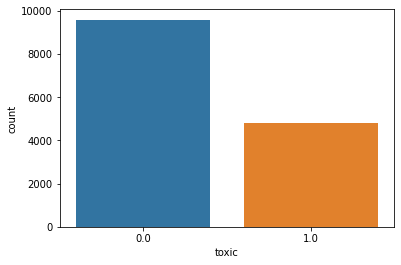

In [6]:
sns.countplot(df['toxic'])

Видим, что токсичных текстов практически в два раза меньше, чем обычных. Это надо будет учесть при разделении данных на тренировочную и тестовую

#Анализ текстов

In [7]:
df['length'] = df['comment'].apply(lambda x: len(x.split()))
for i in df[df.toxic==0][df.length < 10].head()['comment']:
  print(i)

https: pp.userapi.com c848520 v848520411 11627b cOhWqFbGjWE.jpg

Антонио, ты весь в красном!

Не поверите. Н о л ь.

ПОТОМУ ЧТО ЭТО МАСТЕР. А ВЫ ДЕЙСТВИТЕЛЬНО БЕ-БЕ-БЕ..

Извини тебе в грязном ходить приятно?



<ipython-input-7-f34a5559aa08>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.toxic==0][df.length < 10].head()['comment']:


In [8]:
df['length'] = df['comment'].apply(lambda x: len(x.split()))
for i in df[df.toxic==1][df.length < 10].head()['comment']:
  print(i)

Верблюдов-то за что? Дебилы, бл...

Собаке - собачья смерть

Ебать тебя разносит, шизик.

Обосрался, сиди обтекай

Уроды!! у нас в семье 3 поколения там родились



<ipython-input-8-cd78eda5abc2>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.toxic==1][df.length < 10].head()['comment']:


In [9]:
df

,comment,toxic,length
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,5
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,21
2,Собаке - собачья смерть\n,1.0,4
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,32
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,18
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,15
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,17
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,43
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,44


In [10]:
df['eng'] = df['comment'].apply(lambda x: [re.search(r"[A-Za-z]+", i)[0] for i in x.split() if re.search(r"[A-Za-z]+", i)])
df['len_eng'] = df['eng'].apply(lambda x: len(x))

In [11]:
df[df.len_eng > 0]['eng']

11                                               [planeta]
12       [https, pikabu, story, obyichnyie, budni, dezs...
17                       [RIVA, TNT, Ti, type, c, NFS, MW]
28                       [https, pp, c, v, b, cOhWqFbGjWE]
34                                             [glassdoor]
                               ...                        
14306                                               [RYTP]
14331                                             [in, in]
14343                                      [Turtle, Power]
14401                                   [glav, cont, news]
14410                                                  [b]
Name: eng, Length: 976, dtype: object

In [12]:
df['length'] = df['comment'].str.len()
df['tox'] = df['toxic'].apply(lambda x: 'positive' if x == 0 else 'negative')

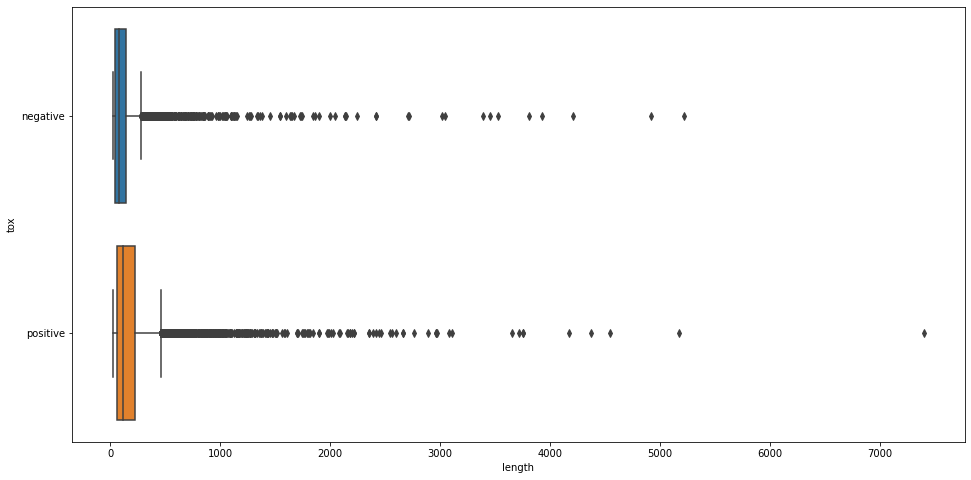

In [13]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df, x='length', y='tox')

Видим, что практически нет разницы в длине коментария в зависимости от того, токсичен он или нет. Поэтому удалим этот параметр

In [14]:
df.drop(['length', 'tox', 'eng', 'len_eng'], axis=1, inplace=True)

Посмотрим некоторые примеры комментариев для того, чтобы понять, как их необходимо предобработать перед самим обучением

In [15]:
df['comment'][12]

'Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098\n'

In [16]:
df['comment'][38]

'В СОВКЕ САМОЕ ЛУЧШЕЕ ОБРАЗОВАНИЕ! - ПО МНЕНИЮ ЛЮБИТЕЛЕЙ ЗАРЯЖАТЬ ВОДУ ОТ ТЕЛЕВИЗОРА В СОВКЕ САМЫЕ КРАСИВЫЕ ДЕВУШКИ! - ПО МНЕНИЮ НОВИОПОВ В СОВКЕ САМЫЕ ЛУЧШИЕ ТОВАРЫ!- ПО МНЕНИЮ ЛЮБИТЕЛЕЙ ПОДТИРАТЬ ЖОПУ ГАЗЕТОЙ, А НЕ ТУАЛЕТНОЙ БУМАГОЙ В СОВКЕ САМАЯ ЛУЧШАЯ МЕДЕЦИНА! - ПО МНЕНИЮ САМОГО АБОРТИРУЕМОГО НАРОДА В СОВКЕ САМАЯ ЛУЧШАЯ ТЕХНИКА! - ПО МНЕНИЮ ЛЮБИТЕЛЕЙ ПЛАГИАТА В СОВКЕ САМЫЙ ВЫСОКИЙ УРОВЕНЬ ЖИЗНИ! - ПО МНЕНИЮ ЛЮБИТЕЛЕЙ ДЕФИЦИТА\n'

In [17]:
df['comment'][135]

'пруф или пи..бол шарлатан)\n'

In [18]:
for neg in df[df['toxic'] == 1]['comment'].head():
    print(neg)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [19]:
for pos in df[df['toxic'] == 0]['comment'].head():
    print(pos)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

#Предварительная обработка текстов

Были замечены различные сайты в текстах, то есть ссылки. Также различные символы для очертания текста, такие как \n. Затем различная лишняя пунктуация или символы скобок

In [20]:
stopwords_rus = stopwords.words('russian')
stemmer = SnowballStemmer('russian')
morph = pymorphy2.MorphAnalyzer()

In [21]:
rar = ['всё', 'вообще', 'это', 'просто', 'тебе', 'которые', 'ещё', 'который']

In [22]:
def preproc(text):
  text = text.lower()
  text = re.sub(r"http\S+", "", text)
  text = str.replace(text,'ё','е')
  text = text.replace(r'[A-Za-z]+', '')
  text = text.replace(r'\<[^>]*\>', '')
  text = re.sub(r'\d+', '', text)
  text = re.sub("[^А-Яа-я -]", "", text)
  text = text.strip()
  text = ' '.join([word for word in word_tokenize(text, language = 'russian') if word not in stopwords_rus])
  text = ' '.join([word for word in word_tokenize(text, language = 'russian') if word not in rar])
  return text


In [23]:
df['comment'] = df['comment'].apply(preproc)
df

,comment,toxic
0,верблюдов-то дебилы бл,1.0
1,хохлы отдушина затюканого россиянина мол вон х...,1.0
2,собаке - собачья смерть,1.0
3,страницу обнови дебил оскорбление доказанный ф...,1.0
4,убедил -страничный пдф скрипалей отравила росс...,1.0
...,...,...
14407,вонючий совковый скот прибежал ноет сторонник ...,1.0
14408,кого любить гоблина тупорылого что-ли какую-ни...,1.0
14409,посмотрел утомленных солнцем оказалось хороший...,0.0
14410,крымотред нарушает правила раздела тк нем обсу...,1.0


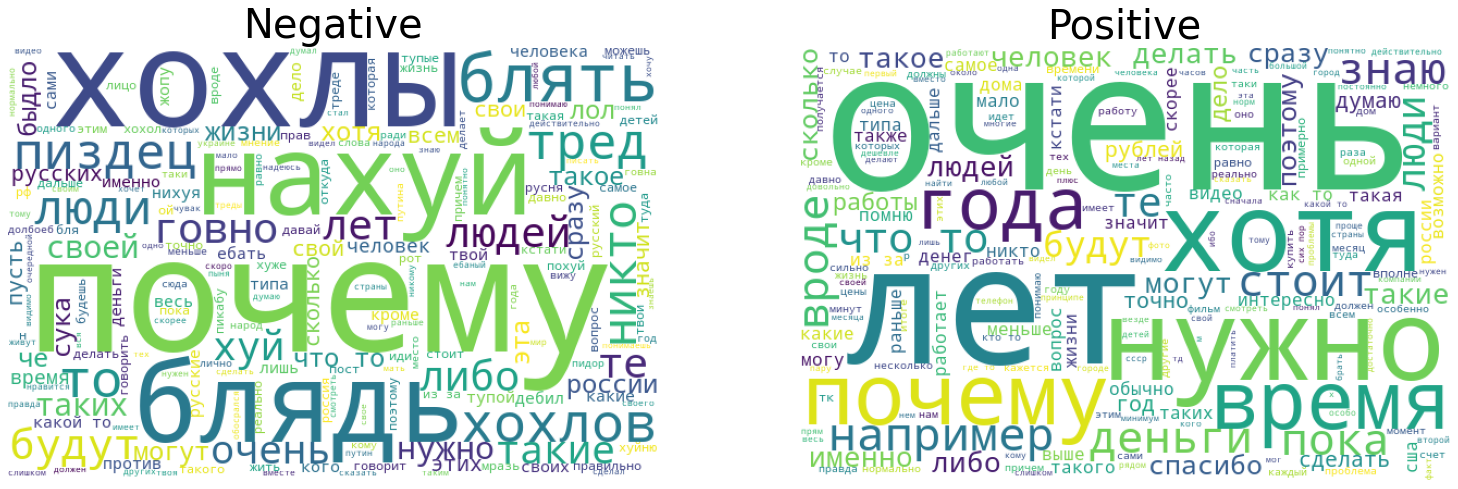

In [24]:
from wordcloud import WordCloud
a = 0
if a == 0:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
  wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(df.comment[df['toxic'] == 1]))
  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title('Negative',fontsize=40);

  wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(df.comment[df['toxic'] == 0]))
  ax2.imshow(wordcloud2)
  ax2.axis('off')
  ax2.set_title('Positive',fontsize=40);

In [25]:
def tokenize(sentence):
    sentence = preproc(sentence)
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stopwords_rus]
    return tokens

def tokenize_stem(sentence):
    sentence = preproc(sentence)
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stopwords_rus]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

def tokenize_lem(sentence):
    sentence = preproc(sentence)
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stopwords_rus]
    tokens = [morph.parse(i)[0].normal_form for i in tokens]
    return tokens

In [26]:
a = """Страницу обнови, дебила кусок. https://dfb.rf Это тоже не оскорбление, 
а доказанный факт - не дебил про себя во множественном числе писать не будет.\n 7841"""
print(a)


Страницу обнови, дебила кусок. https://dfb.rf Это тоже не оскорбление, 
а доказанный факт - не дебил про себя во множественном числе писать не будет.
 7841


In [27]:
print(tokenize_stem(a))

['страниц', 'обнов', 'деб', 'кусок', 'оскорблен', 'доказа', 'факт', 'деб', 'множествен', 'числ', 'писа']


In [28]:
print(tokenize_lem(a))

['страница', 'обновить', 'дебил', 'кусок', 'оскорбление', 'доказать', 'факт', 'дебил', 'множественный', 'число', 'писать']


In [29]:
from sklearn.model_selection import train_test_split
X = df['comment']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

#Base-Params


In [32]:
def scoring_base_params(model, tokenizer):
  model_pipeline = Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenizer(x))),
      ('model', model())])
  model_pipeline.fit(X_train, y_train)
  pred = model_pipeline.predict(X_test)
  return precision_score(pred, y_test), recall_score(pred, y_test), f1_score(pred, y_test)

In [34]:
scores_base = {}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(LogisticRegression, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(LogisticRegression, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(LogisticRegression, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['LogisticRegression'] = [score_1, score_2, score_3]

For simple tokenize:
	 Precision = 0.44559585492227977
	 Recall = 0.9207708779443254
	 F1 = 0.6005586592178771
For stemming tokenize:
	 Precision = 0.6031088082901555
	 Recall = 0.9023255813953488
	 F1 = 0.7229813664596273
For lematiaztion tokenize:
	 Precision = 0.6113989637305699
	 Recall = 0.913312693498452
	 F1 = 0.7324643078833023


In [35]:
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(LinearSVC, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(LinearSVC, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(LinearSVC, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['LinearSVC'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.6673575129533679
	 Recall = 0.8507265521796565
	 F1 = 0.7479674796747967
For stemming tokenize:
	 Precision = 0.7150259067357513
	 Recall = 0.8571428571428571
	 F1 = 0.7796610169491526
For lematiaztion tokenize:
	 Precision = 0.7212435233160622
	 Recall = 0.8613861386138614
	 F1 = 0.7851099830795262


In [36]:
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(DecisionTreeClassifier, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(DecisionTreeClassifier, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(DecisionTreeClassifier, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['DecisionTree'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.5347150259067357
	 Recall = 0.6954177897574124
	 F1 = 0.6045694200351494
For stemming tokenize:
	 Precision = 0.6113989637305699
	 Recall = 0.7186358099878197
	 F1 = 0.6606942889137737
For lematiaztion tokenize:
	 Precision = 0.6145077720207254
	 Recall = 0.7214111922141119
	 F1 = 0.663682148852826


In [38]:
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(RandomForestClassifier, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(RandomForestClassifier, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(RandomForestClassifier, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['RandomForest'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.5191709844559586
	 Recall = 0.8564102564102564
	 F1 = 0.6464516129032258
For stemming tokenize:
	 Precision = 0.5948186528497409
	 Recall = 0.8618618618618619
	 F1 = 0.703862660944206
For lematiaztion tokenize:
	 Precision = 0.583419689119171
	 Recall = 0.8810641627543035
	 F1 = 0.701995012468828


In [39]:
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(MultinomialNB, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(MultinomialNB, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(MultinomialNB, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['MultinomialNB'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.3077720207253886
	 Recall = 0.954983922829582
	 F1 = 0.4655172413793104
For stemming tokenize:
	 Precision = 0.44974093264248705
	 Recall = 0.9601769911504425
	 F1 = 0.6125617501764291
For lematiaztion tokenize:
	 Precision = 0.45284974093264246
	 Recall = 0.9668141592920354
	 F1 = 0.6167960479887086


In [40]:
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_base_params(ComplementNB, tokenize)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_base_params(ComplementNB, tokenize_stem)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_base_params(ComplementNB, tokenize_lem)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_base['ComplementNB'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.6207253886010363
	 Recall = 0.886094674556213
	 F1 = 0.7300426569165144
For stemming tokenize:
	 Precision = 0.677720207253886
	 Recall = 0.9083333333333333
	 F1 = 0.7762611275964393
For lematiaztion tokenize:
	 Precision = 0.6766839378238342
	 Recall = 0.9107391910739191
	 F1 = 0.7764565992865636


In [41]:
pd.DataFrame(scores_base, index=['token', 'stem', 'lem'])

,LogisticRegression,LinearSVC,DecisionTree,RandomForest,MultinomialNB,ComplementNB
token,0.6006,0.7480,0.6046,0.6465,0.4655,0.7300
stem,0.7230,0.7797,0.6607,0.7039,0.6126,0.7763
lem,0.7325,0.7851,0.6637,0.7020,0.6168,0.7765


#Best_Params

In [42]:
def scoring_best_params(model, tokenizer, params):
  model_pipeline = Pipeline([
      ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenizer(x))),
      ('model', GridSearchCV(model(), params, cv=5, scoring='f1'))])
  model_pipeline.fit(X_train, y_train)
  pred = model_pipeline.predict(X_test)
  return precision_score(pred, y_test), recall_score(pred, y_test), f1_score(pred, y_test)

In [43]:
scores_best = {}
params = {'C': [0.1, 0.5, 1, 10]}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(LogisticRegression, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(LogisticRegression, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(LogisticRegression, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['LogisticRegression'] = [score_1, score_2, score_3]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

For simple tokenize:
	 Precision = 0.6383419689119171
	 Recall = 0.8627450980392157
	 F1 = 0.7337701012507446


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

For stemming tokenize:
	 Precision = 0.7150259067357513
	 Recall = 0.8614232209737828
	 F1 = 0.7814269535673839


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

For lematiaztion tokenize:
	 Precision = 0.7150259067357513
	 Recall = 0.8701134930643127
	 F1 = 0.7849829351535836


In [44]:
params = {'penalty': ['l1', 'l2'], 'C' : range(1, 10, 2)}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(LinearSVC, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(LinearSVC, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(LinearSVC, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['LinearSVC'] = [score_1, score_2, score_3]


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty

For simple tokenize:
	 Precision = 0.6922279792746114
	 Recall = 0.8226600985221675
	 F1 = 0.7518289251547552


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty

For stemming tokenize:
	 Precision = 0.7150259067357513
	 Recall = 0.8571428571428571
	 F1 = 0.7796610169491526


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty

For lematiaztion tokenize:
	 Precision = 0.7212435233160622
	 Recall = 0.8613861386138614
	 F1 = 0.7851099830795262


In [45]:
params = {'criterion': ['gini', 'entropy'], 'max_depth' : range(5, 200, 40)}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(DecisionTreeClassifier, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(DecisionTreeClassifier, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(DecisionTreeClassifier, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['DecisionTree'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.3689119170984456
	 Recall = 0.8109339407744874
	 F1 = 0.5071225071225072
For stemming tokenize:
	 Precision = 0.5119170984455959
	 Recall = 0.7706708268330733
	 F1 = 0.6151930261519303
For lematiaztion tokenize:
	 Precision = 0.5119170984455959
	 Recall = 0.765891472868217
	 F1 = 0.6136645962732918


In [49]:
params = {'criterion': ['gini', 'entropy'], 'max_depth' : range(50, 250, 50)}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(RandomForestClassifier, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(RandomForestClassifier, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(RandomForestClassifier, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['RandomForest'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.34404145077720205
	 Recall = 0.9299719887955182
	 F1 = 0.5022692889561271
For stemming tokenize:
	 Precision = 0.48911917098445595
	 Recall = 0.9076923076923077
	 F1 = 0.6356902356902357
For lematiaztion tokenize:
	 Precision = 0.49015544041450776
	 Recall = 0.904397705544933
	 F1 = 0.635752688172043


In [50]:
params = {'alpha' : [0.01, 0.1, 1, 2, 5, 10, 20]}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(MultinomialNB, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(MultinomialNB, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(MultinomialNB, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['MultinomialNB'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.6518134715025907
	 Recall = 0.8871650211565585
	 F1 = 0.7514934289127838
For stemming tokenize:
	 Precision = 0.6880829015544041
	 Recall = 0.9120879120879121
	 F1 = 0.7844063792085056
For lematiaztion tokenize:
	 Precision = 0.6870466321243524
	 Recall = 0.8983739837398373
	 F1 = 0.7786259541984732


In [51]:
params = {'alpha' : [0.01, 0.1, 1, 2, 5, 10, 20]}
vect = ['tokenize', 'stem', 'lem']
for i in vect:
  if i == 'tokenize':
    scors = scoring_best_params(ComplementNB, tokenize, params)
    print(f'For simple tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_1 = round(scors[2], 4)

  elif i == 'stem':
    scors = scoring_best_params(ComplementNB, tokenize_stem, params)
    print(f'For stemming tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_2 = round(scors[2], 4)

  else:
    scors = scoring_best_params(ComplementNB, tokenize_lem, params)
    print(f'For lematiaztion tokenize:')
    print(f'\t Precision = {scors[0]}')
    print(f'\t Recall = {scors[1]}')
    print(f'\t F1 = {scors[2]}')
    score_3 = round(scors[2], 4)
    scores_best['ComplementNB'] = [score_1, score_2, score_3]


For simple tokenize:
	 Precision = 0.7595854922279792
	 Recall = 0.8301245753114382
	 F1 = 0.7932900432900433
For stemming tokenize:
	 Precision = 0.8062176165803109
	 Recall = 0.8502732240437159
	 F1 = 0.8276595744680852
For lematiaztion tokenize:
	 Precision = 0.7917098445595855
	 Recall = 0.8441988950276244
	 F1 = 0.8171122994652407


In [52]:
pd.DataFrame(scores_best, index=['token', 'stem', 'lem'])

,LogisticRegression,LinearSVC,DecisionTree,RandomForest,MultinomialNB,ComplementNB
token,0.7338,0.7518,0.5071,0.5023,0.7515,0.7933
stem,0.7814,0.7797,0.6152,0.6357,0.7844,0.8277
lem,0.7850,0.7851,0.6137,0.6358,0.7786,0.8171
